# Import libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

from sklearn.model_selection import train_test_split

In [2]:
# Create SQLite database in memory 
conn = sqlite3.connect(":memory:")

# Load CSVs into SQL

In [3]:
# Load categories
categories = pd.read_csv("/kaggle/input/grocery-sales-dataset/categories.csv")
categories.to_sql("categories", conn, index=False, if_exists="replace")

# Load cities
cities = pd.read_csv("/kaggle/input/grocery-sales-dataset/cities.csv")
cities.to_sql("cities", conn, index=False, if_exists="replace")

# Load countries
countries = pd.read_csv("/kaggle/input/grocery-sales-dataset/countries.csv")
countries.to_sql("countries", conn, index=False, if_exists="replace")

# Load customers
customers = pd.read_csv("/kaggle/input/grocery-sales-dataset/customers.csv")
customers.to_sql("customers", conn, index=False, if_exists="replace")

# Load employees
employees = pd.read_csv("/kaggle/input/grocery-sales-dataset/employees.csv")
employees.to_sql("employees", conn, index=False, if_exists="replace")

# Load products
products = pd.read_csv("/kaggle/input/grocery-sales-dataset/products.csv")
products.to_sql("products", conn, index=False, if_exists="replace")

# Load sales 
sales = pd.read_csv("/kaggle/input/grocery-sales-dataset/sales.csv")
sales.to_sql("sales", conn, index=False, if_exists="replace")

6758125

In [42]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,categories
1,cities
2,countries
3,customers
4,employees
5,products
6,sales


In [4]:
tables = ["categories", "cities", "countries", "customers", "employees", "products", "sales"]

# Database Schema

In [44]:
for table in tables:
    grocery_tables = pd.read_sql(f"PRAGMA table_info({table});", conn)
    print(f"{table} table")
    display(grocery_tables)

categories table


,cid,name,type,notnull,dflt_value,pk
0,0,CategoryID,INTEGER,0,None,0
1,1,CategoryName,TEXT,0,None,0


cities table


,cid,name,type,notnull,dflt_value,pk
0,0,CityID,INTEGER,0,None,0
1,1,CityName,TEXT,0,None,0
2,2,Zipcode,INTEGER,0,None,0
3,3,CountryID,INTEGER,0,None,0


countries table


,cid,name,type,notnull,dflt_value,pk
0,0,CountryID,INTEGER,0,None,0
1,1,CountryName,TEXT,0,None,0
2,2,CountryCode,TEXT,0,None,0


customers table


,cid,name,type,notnull,dflt_value,pk
0,0,CustomerID,INTEGER,0,None,0
1,1,FirstName,TEXT,0,None,0
2,2,MiddleInitial,TEXT,0,None,0
3,3,LastName,TEXT,0,None,0
4,4,CityID,INTEGER,0,None,0
5,5,Address,TEXT,0,None,0


employees table


,cid,name,type,notnull,dflt_value,pk
0,0,EmployeeID,INTEGER,0,None,0
1,1,FirstName,TEXT,0,None,0
2,2,MiddleInitial,TEXT,0,None,0
3,3,LastName,TEXT,0,None,0
4,4,BirthDate,TEXT,0,None,0
5,5,Gender,TEXT,0,None,0
6,6,CityID,INTEGER,0,None,0
7,7,HireDate,TEXT,0,None,0


products table


,cid,name,type,notnull,dflt_value,pk
0,0,ProductID,INTEGER,0,None,0
1,1,ProductName,TEXT,0,None,0
2,2,Price,REAL,0,None,0
3,3,CategoryID,INTEGER,0,None,0
4,4,Class,TEXT,0,None,0
5,5,ModifyDate,TEXT,0,None,0
6,6,Resistant,TEXT,0,None,0
7,7,IsAllergic,TEXT,0,None,0
8,8,VitalityDays,REAL,0,None,0


sales table


,cid,name,type,notnull,dflt_value,pk
0,0,SalesID,INTEGER,0,None,0
1,1,SalesPersonID,INTEGER,0,None,0
2,2,CustomerID,INTEGER,0,None,0
3,3,ProductID,INTEGER,0,None,0
4,4,Quantity,INTEGER,0,None,0
5,5,Discount,REAL,0,None,0
6,6,TotalPrice,REAL,0,None,0
7,7,SalesDate,TEXT,0,None,0
8,8,TransactionNumber,TEXT,0,None,0


# Data Analysis

## 1. Monthly Sales Performance

### Calculate total sales for each month.

In [8]:
query = """
        SELECT strftime("%Y-%m", s.SalesDate) AS month,
               SUM(s.Quantity * p.Price) AS TotalSales
        FROM sales AS s
        INNER JOIN products AS p
         ON s.productID = p.productID
        GROUP BY month
        ORDER BY month 
        """
pd.read_sql(query, conn)

,month,TotalSales
0,None,4.454927e+07
1,2018-01,1.062478e+09
2,2018-02,9.578795e+08
3,2018-03,1.064094e+09
4,2018-04,1.028151e+09
5,2018-05,3.091073e+08


* The TotalSales column in the sales table was intentionally set to 0.0 as a placeholder. The total sales is calculated by joining the sales and products tables and computing revenue as Quantity × Price

### Compare sales performance across different product categories each month.

In [4]:
query ="""
       SELECT c.CategoryName,
              strftime("%Y-%m", s.SalesDate) AS month,
              SUM(s.Quantity * p.Price) AS TotalSales
       FROM categories as c
        LEFT JOIN products as p
          ON c.CategoryID = p.CategoryID
        LEFT JOIN sales as s
          ON s.ProductID = p.ProductID
            WHERE s.SalesDate != "None"
        GROUP BY CategoryName, month
        ORDER BY TotalSales DESC
       """
category_monthly_sale = pd.read_sql(query, conn)
category_monthly_sale

,CategoryName,month,TotalSales
0,Confections,2018-01,1.369301e+08
1,Confections,2018-03,1.366710e+08
2,Confections,2018-04,1.319832e+08
3,Confections,2018-02,1.227144e+08
4,Meat,2018-03,1.211585e+08
5,Meat,2018-01,1.207132e+08
6,Meat,2018-04,1.171840e+08
7,Meat,2018-02,1.086352e+08
8,Poultry,2018-01,1.079895e+08
9,Poultry,2018-03,1.079704e+08


**Insights:** Confections generated the highest revenue continuously across 4 months, although poultry/meat and cereal also genrated a good revenue too

### Visualization of category monthly sale

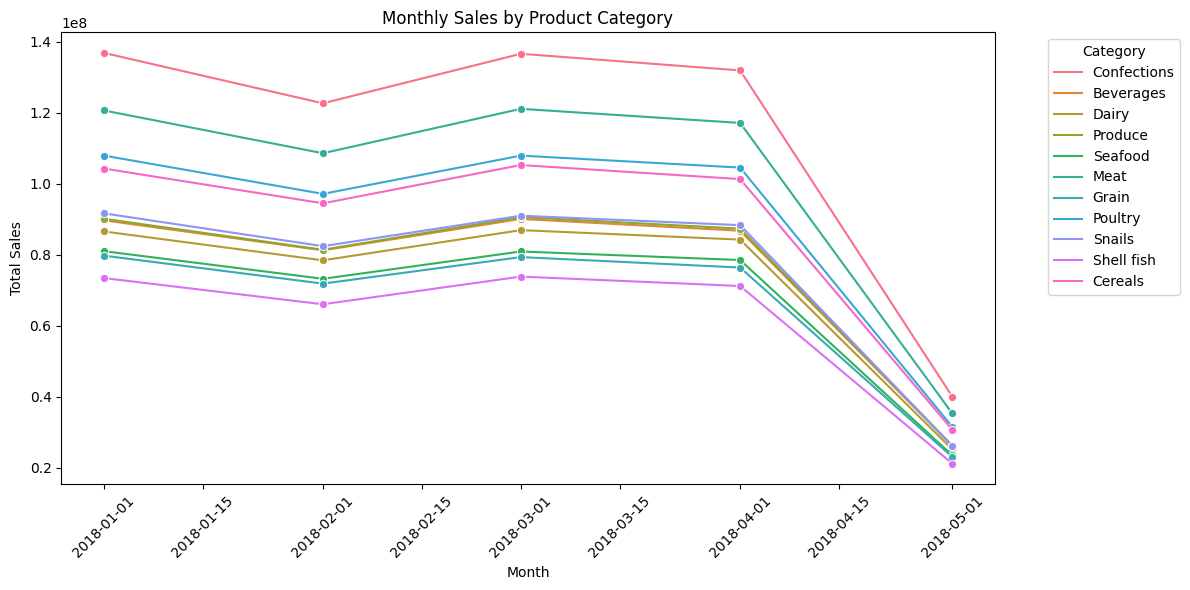

In [8]:
category_monthly_sale['month'] = pd.to_datetime(category_monthly_sale['month'])
category_monthly_sale = category_monthly_sale.sort_values('month')

# Multi-line chart
plt.figure(figsize=(12,6))
sns.lineplot(data=category_monthly_sale, x='month', y='TotalSales', hue='CategoryName', marker='o')
plt.title('Monthly Sales by Product Category')
plt.ylabel('Total Sales')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Observation**: 
* Confections have the highest sales in the grocery category.

* In the first month of the year, sales of all product categories went slightly down, which is unusual because people often buy more at the beginning of the year.

* In the second month, sales slightly increased across most categories.

* In the third month, some categories remained fairly consistent, while others experienced a minor decline.

* In the fourth month, sales across all categories dropped significantly, which is a major concern.

**Suggestions**:
* Introduce New Year discounts and promotions in the first month to attract more customers.

* Investigate the fourth month’s sales decline if it was due to lack or promotions, seasonal trends, etc. 

* Consider introducing targeted campaigns or loyalty rewards to prevent such drastic drops in the future.

## 2. Top Products Identification

### Rank products based on total sales revenue.

In [10]:
query = """
        WITH ProductRevenue AS (
            SELECT p.ProductName,
                   SUM(s.Quantity * p.Price) AS TotalSalesRevenue
            FROM products AS p
                JOIN sales AS s
                  ON p.ProductID = s.ProductID
            GROUP BY ProductName
        )

        SELECT ProductName,
               TotalSalesRevenue,
               ROUND(
    CAST(100.0 * TotalSalesRevenue / (SELECT SUM(TotalSalesRevenue) FROM ProductRevenue) AS NUMERIC), 
    2
) AS RevenuePercentage
        FROM ProductRevenue
        ORDER BY TotalSalesRevenue DESC
        """
pd.read_sql(query, conn)

,ProductName,TotalSalesRevenue,RevenuePercentage
0,Bread - Calabrese Baguette,1.944911e+07,0.44
1,Shrimp - 31/40,1.929934e+07,0.43
2,Tia Maria,1.927706e+07,0.43
3,Puree - Passion Fruit,1.926688e+07,0.43
4,Zucchini - Yellow,1.912267e+07,0.43
...,...,...,...
447,Bread Fig And Almond,2.296707e+05,0.01
448,"Sole - Dover, Whole, Fresh",1.339201e+05,0.00
449,Pastry - Raisin Muffin - Mini,8.342357e+04,0.00
450,Apricots - Halves,7.340508e+04,0.00


**Insight:** A small group of products (like Calabrese Baguette, Shrimp, and Tia Maria, Puree, Zucchini) generate a disproportionately large share of revenue (over 40% each), while many other products contribute very little. This shows that the business relies heavily on a few high-performing items, and focusing on them could maximize profits.

### Examine the impact of product classifications on sales performance.

In [12]:
query ="""
       SELECT c.CategoryName,
              SUM(s.Quantity * p.Price) AS TotalSales
       FROM categories as c
        LEFT JOIN products as p
          ON c.CategoryID = p.CategoryID
        LEFT JOIN sales as s
          ON s.ProductID = p.ProductID
        GROUP BY CategoryName
        ORDER BY TotalSales DESC
       """
pd.read_sql(query, conn)

,CategoryName,TotalSales
0,Confections,5.741033e+08
1,Meat,5.081144e+08
2,Poultry,4.536139e+08
3,Cereals,4.406495e+08
4,Snails,3.836018e+08
5,Produce,3.796767e+08
6,Beverages,3.778775e+08
7,Dairy,3.652247e+08
8,Seafood,3.407239e+08
9,Grain,3.338634e+08


* This shows that Confections, Meat, and Poultry drive the highest sales, while categories like Shellfish and Grain contribute the least, highlighting where demand is strongest.

### Analyze sales quantity and revenue to identify high-demand products.

In [7]:
query = """
        SELECT p.ProductName,
               SUM(s.Quantity) AS TotalQuantity,
               SUM(s.Quantity * p.Price) AS TotalSalesRevenue
        FROM products AS p
        JOIN sales AS s
            ON p.ProductID = s.ProductID
        GROUP BY p.ProductName
        ORDER BY TotalSalesRevenue DESC
         """
high_demand_products = pd.read_sql(query, conn)
high_demand_products

,ProductName,TotalQuantity,TotalSalesRevenue
0,Bread - Calabrese Baguette,197257,1.944911e+07
1,Shrimp - 31/40,193234,1.929934e+07
2,Tia Maria,196210,1.927706e+07
3,Puree - Passion Fruit,194957,1.926688e+07
4,Zucchini - Yellow,194209,1.912267e+07
...,...,...,...
447,Bread Fig And Almond,193293,2.296707e+05
448,"Sole - Dover, Whole, Fresh",195618,1.339201e+05
449,Pastry - Raisin Muffin - Mini,195006,8.342357e+04
450,Apricots - Halves,196533,7.340508e+04


**Insights:** The quantity definitely influence the revenue, the products that generate more revenue are actually in high demand but also a few low-volume products still bring high revenue because they sell at higher prices.

## 3. Customer Purchase Behavior


### Segment customers based on their purchase frequency and total spend.

In [9]:
query = """
        SELECT s.CustomerID,
               COUNT(s.SalesID) AS purchaseFrequency,
               SUM(s.Quantity * p.Price) AS TotalSpend
        FROM sales AS s
        JOIN products AS p
         ON s.ProductID = p.ProductID
        GROUP BY CustomerID
        ORDER BY TotalSpend DESC
        """
customer_purchase = pd.read_sql(query, conn)
customer_purchase

,CustomerID,purchaseFrequency,TotalSpend
0,94800,103,134409.8328
1,95972,97,127844.7325
2,95048,96,126282.1575
3,97863,94,125921.4750
4,95157,96,124663.1275
...,...,...,...
98754,2106,50,2082.8124
98755,2991,46,2070.2871
98756,2568,42,2066.2401
98757,1072,50,2051.2740


### Scatter Plot Visualization : Purchase Frequency vs Total Spend

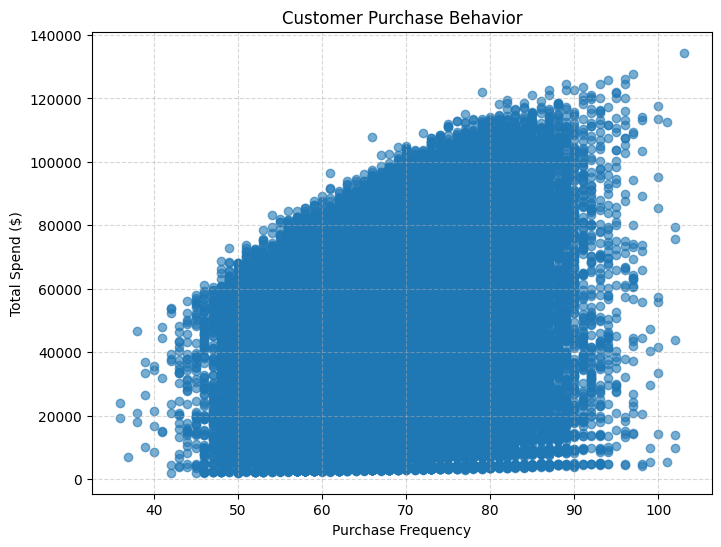

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(customer_purchase['purchaseFrequency'], customer_purchase['TotalSpend'], alpha=0.6)
plt.title("Customer Purchase Behavior")
plt.xlabel("Purchase Frequency")
plt.ylabel("Total Spend ($)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


**Insights:** There is a linear relationship between purchase frequency and total money spent. This means that frequent buyers are key drivers of revenue

**Suggestions:**
* Meduim-frequency spenders can be encouraged to spend more by giving them discounts when they buy a particular amount of products
* Retain high-frequency, high-spend customers by introducing a loyalty program (e.g coupons)

### Identify repeat customers versus one-time buyers.

In [14]:
query = """
WITH customer_orders AS (
    SELECT 
        CustomerID,
        COUNT(DISTINCT SalesID) AS num_orders
    FROM sales
    GROUP BY CustomerID
)
SELECT
    CASE 
        WHEN num_orders = 1 THEN 'One-time Buyer'
        ELSE 'Repeat Customer'
    END AS customer_type,
    COUNT(*) AS num_customers
FROM customer_orders
GROUP BY customer_type
"""

pd.read_sql(query, conn)


,customer_type,num_customers
0,Repeat Customer,98759


* There are no one-time buyer

## 4. Salesperson Effectiveness

### Calculate total sales attributed to each salesperson.

In [29]:
query = """
        SELECT s.SalesPersonID,
               e.FirstName,
               e.LastName,
               COUNT(*) AS number_of_sales,
               SUM(s.Quantity * p.Price) AS TotalSales
        FROM sales AS s
         JOIN products AS p
          ON p.ProductID = s.productID
         LEFT JOIN employees AS e
          ON e.employeeID = s.SalesPersonID
        GROUP BY SalesPersonID
        ORDER BY TotalSales DESC
        """
salesperson_sales = pd.read_sql(query, conn)
salesperson_sales

,SalesPersonID,FirstName,LastName,number_of_sales,TotalSales
0,21,Devon,Brewer,294983,1.958713e+08
1,20,Shelby,Riddle,293562,1.952435e+08
2,13,Katina,Marks,293530,1.951563e+08
3,5,Desiree,Stuart,293711,1.950589e+08
4,4,Darnell,Nielsen,294744,1.949594e+08
5,14,Wendi,Buckley,294035,1.948515e+08
6,22,Tonia,Mc Millan,293224,1.946734e+08
7,8,Julie,Dyer,294449,1.946465e+08
8,7,Chadwick,Cook,293967,1.946417e+08
9,6,Holly,Collins,293973,1.946314e+08


### Visualization of Salesperson Performance: Total Sales vs Number of Sales

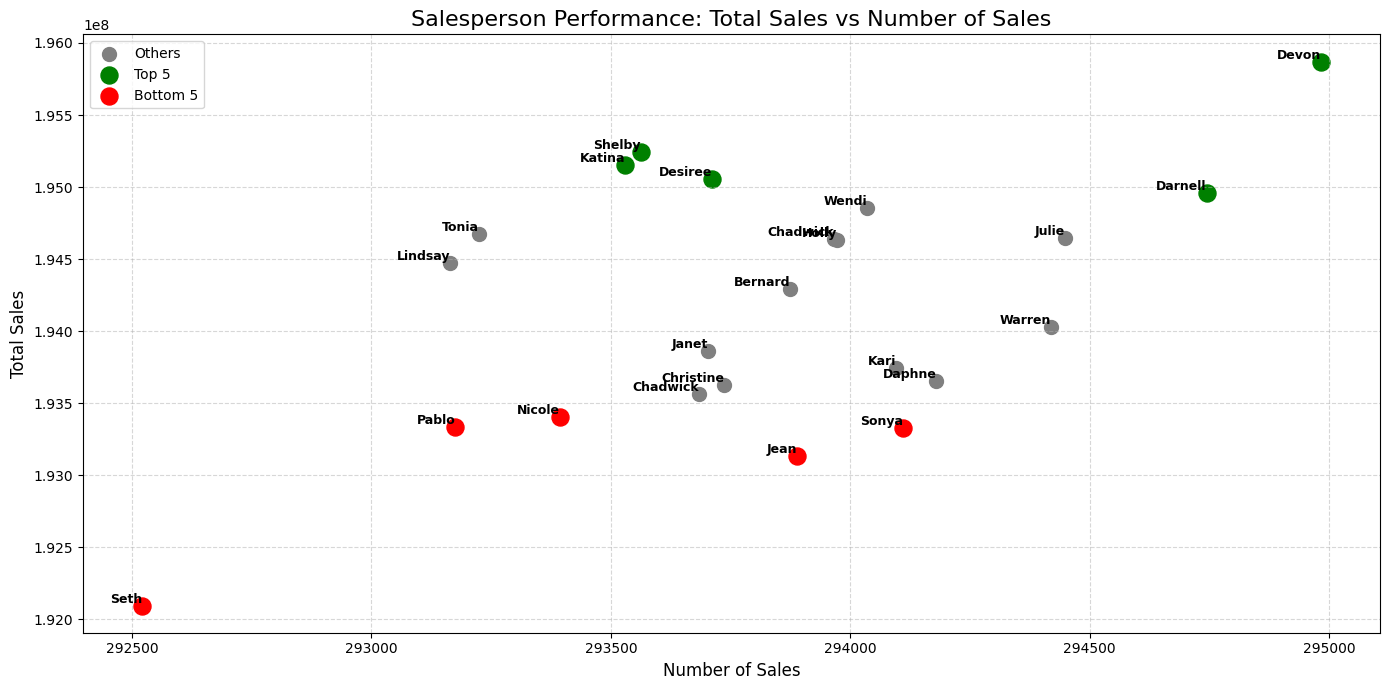

In [39]:

# Highlight top 5 and bottom 5
top5 = salesperson_sales.head(5)
bottom5 = salesperson_sales.tail(5)
others = salesperson_sales.iloc[5:-5]

plt.figure(figsize=(14,7))

# Plot others in gray
plt.scatter(others['number_of_sales'], others['TotalSales'], 
            color='gray', s=100, label='Others')

# Top 5 in green
plt.scatter(top5['number_of_sales'], top5['TotalSales'], 
            color='green', s=150, label='Top 5')

# Bottom 5 in red
plt.scatter(bottom5['number_of_sales'], bottom5['TotalSales'], 
            color='red', s=150, label='Bottom 5')

# Annotate all points with first name
for i, row in salesperson_sales.iterrows():
    plt.text(row['number_of_sales'], row['TotalSales'], 
             row['FirstName'], fontsize=9, fontweight='bold', ha='right', va='bottom')

plt.title("Salesperson Performance: Total Sales vs Number of Sales", fontsize=16)
plt.xlabel("Number of Sales", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()




**Insight:**
There is a noticeable variation in sales performance among salespeople. Top performers like Devon and Darnell achieve both high sales volume and high revenue, while Seth has low sales and revenue. Some bottom performers have similar sales counts to others but generate less revenue due to lower-priced customer purchases, highlighting that outcomes are influenced not just by effort but also by the value of products sold. This shows a mix of effort, skill, and “luck” in customer purchasing behavior.

**Suggestions:**

* Recognize and reward top performers like Devon and Darnell for both effort and revenue contribution.

* Provide targeted support or training to lower-performing salespeople like Seth to improve their performance.

* Consider incentives that balance both quantity of sales and revenue generated, ensuring fairness and motivation across the team.

### Analyze sales trends based on individual salesperson contributions over time.

In [24]:
query = """
SELECT s.SalesPersonID,
       strftime("%Y-%m", s.SalesDate) AS month,
       SUM(s.Quantity * p.Price) AS TotalSales
FROM sales AS s
 JOIN products AS p
  ON p.ProductID = s.ProductID
WHERE month != "None"
GROUP BY salesPersonID, month
ORDER BY SalesPersonID, month,TotalSales DESC

"""
salesperson_contribution = pd.read_sql(query, conn)
salesperson_contribution

,SalesPersonID,month,TotalSales
0,1,2018-01,4.575897e+07
1,1,2018-02,4.158856e+07
2,1,2018-03,4.634132e+07
3,1,2018-04,4.423819e+07
4,1,2018-05,1.353406e+07
...,...,...,...
110,23,2018-01,4.589244e+07
111,23,2018-02,4.190496e+07
112,23,2018-03,4.581376e+07
113,23,2018-04,4.485689e+07


## 5. Geographical Sales Insights

### Compare sales volumes between various geographical areas.

In [38]:
query = """
        SELECT co.CountryName,
               SUM(s.Quantity * p.Price) AS TotalSales
        FROM sales AS s
         JOIN customers AS c
           ON s.CustomerID = c.CustomerID
         JOIN cities AS ci
           ON c.CityID = ci.CityID
         JOIN countries AS co
           ON ci.CountryID = co.CountryID
         JOIN products AS p
           ON s.ProductID = p.ProductID
        GROUP BY co.CountryName
        ORDER BY TotalSales DESC;
        """
pd.read_sql(query, conn)

,CountryName,TotalSales
0,United States,4.466259e+09


Only one country, UnitedStates

### Map sales data to specific cities and countries to identify high-performing regions.

In [41]:
query = """
        SELECT ci.CityName,
               co.CountryName,
               SUM(s.Quantity * p.Price) AS TotalSales
        FROM sales AS s
         JOIN customers AS c
           ON s.CustomerID = c.CustomerID
         JOIN cities AS ci
           ON c.CityID = ci.CityID
         JOIN countries AS co
           ON ci.CountryID = co.CountryID
         JOIN products AS p
           ON s.ProductID = p.ProductID
        GROUP BY ci.CityName, co.CountryName
        ORDER BY TotalSales DESC;
        """
city_sales = pd.read_sql(query, conn)
city_sales

,CityName,CountryName,TotalSales
0,Tucson,United States,5.034625e+07
1,Jackson,United States,4.992563e+07
2,Sacramento,United States,4.969993e+07
3,Fort Wayne,United States,4.914039e+07
4,Indianapolis,United States,4.884950e+07
...,...,...,...
91,New Orleans,United States,4.431983e+07
92,Fort Worth,United States,4.371010e+07
93,Atlanta,United States,4.369828e+07
94,Long Beach,United States,4.351019e+07


**Observation:** The top 5 cities by total sales are Tucson, Jackson, Sacramento, Fort Wayne, and Indianapolis, while the bottom 5 are New Orleans, Fort Worth, Atlanta, Long Beach, and Omaha. This indicates certain cities are consistently generating higher revenue than others.

# EXPLORATORY DATA ANALYSIS(EDA)

In [11]:
query = """
        SELECT CAST(strftime('%W', s.salesDate) AS INTEGER) AS week_number,   
               p.CategoryID,
               c.CityID,
               SUM(s.quantity) AS total_quantity
        FROM sales AS s
        JOIN products AS p 
          ON s.ProductID = p.ProductID
        JOIN customers AS c
          ON s.CustomerID = c.CustomerID
        GROUP BY week_number, 
                 p.CategoryID, 
                 c.CityID
        ORDER BY week_number, 
                 c.CityID 
        """
df = pd.read_sql(query, conn)
df

,week_number,CategoryID,CityID,total_quantity
0,NaN,1,1,1169
1,NaN,2,1,871
2,NaN,3,1,859
3,NaN,4,1,897
4,NaN,5,1,763
...,...,...,...,...
21115,19.0,7,96,2172
21116,19.0,8,96,1259
21117,19.0,9,96,2331
21118,19.0,10,96,1918


In [18]:
df.describe()

,week_number,CategoryID,CityID,total_quantity
count,20064.000000,21120.000000,21120.000000,21120.000000
mean,10.000000,6.000000,48.500000,4161.113068
std,5.477362,3.162353,27.711965,1280.488111
min,1.000000,1.000000,1.000000,389.000000
25%,5.000000,3.000000,24.750000,3662.000000
50%,10.000000,6.000000,48.500000,4177.500000
75%,15.000000,9.000000,72.250000,5002.000000
max,19.000000,11.000000,96.000000,7865.000000


* 19 number of weeks
* 11 categories of products
* 96 cities/stores

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21120 entries, 0 to 21119
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   week_number     20064 non-null  float64
 1   CategoryID      21120 non-null  int64  
 2   CityID          21120 non-null  int64  
 3   total_quantity  21120 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 660.1 KB


## Missing values

In [20]:
df.isna().sum()

week_number       1056
CategoryID           0
CityID               0
total_quantity       0
dtype: int64

* There are missing week numbers

In [21]:
df = df.dropna()

In [22]:
df.isna().sum()

week_number       0
CategoryID        0
CityID            0
total_quantity    0
dtype: int64

* I dropped the missing rows because they had no useful weekly command data and keeping them would only add noise without contributing to the model.

## Checking for Outliers

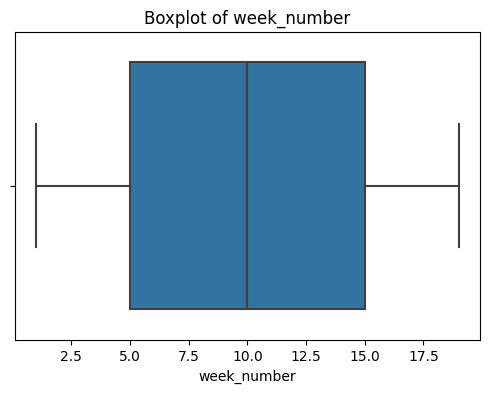

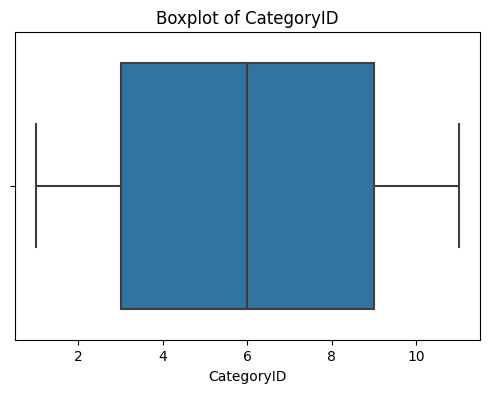

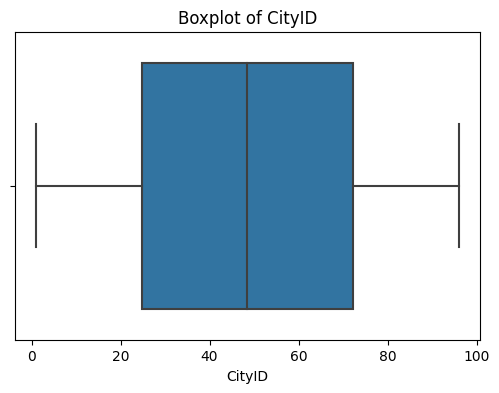

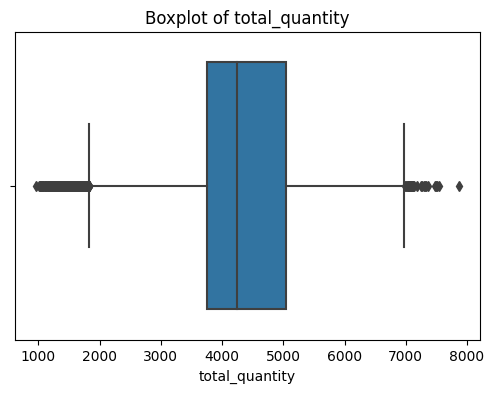

In [23]:
# Check outliers for each numerical column
cols = ['week_number', 'CategoryID', 'CityID','total_quantity']  # add others if needed

for col in cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


* Outliers were detected in total_quantity, but I chose not to remove them since that’s my target variable. These variations represent real-life situations, like when customers place unusually large orders. If I drop them, the model might fail to capture those cases. Keeping the outliers makes the data more realistic and helps the model learn to predict more accurately in real-world scenarios.

## Checking for skewness

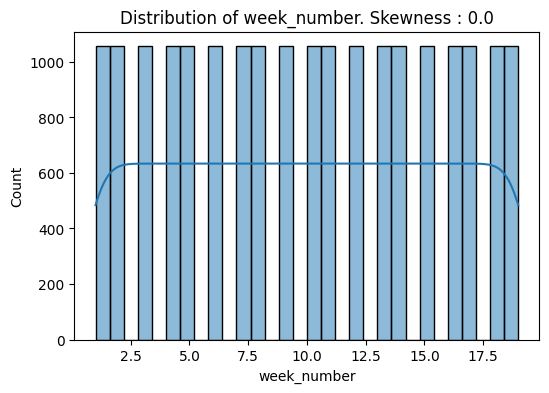

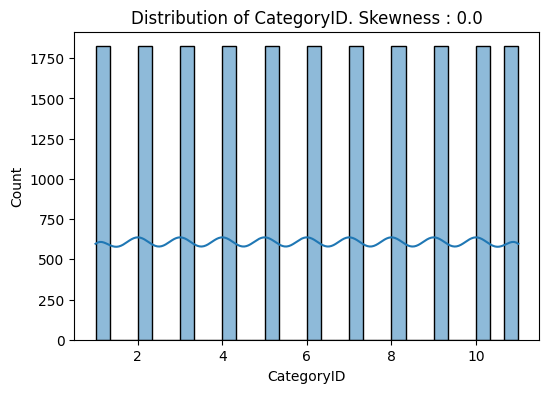

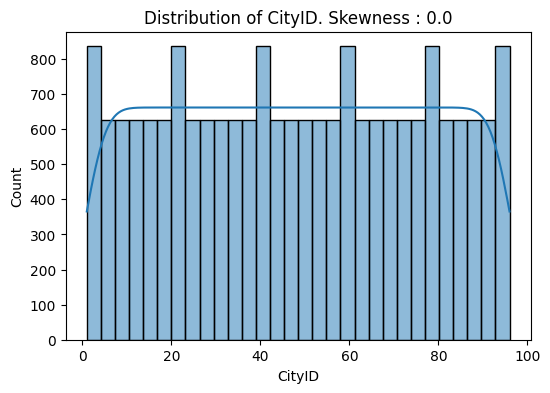

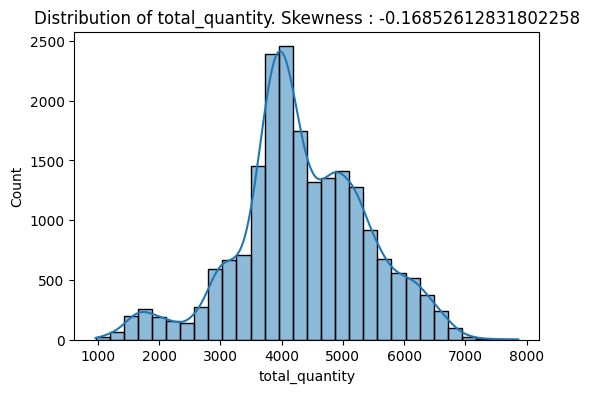

In [24]:
for col in cols:
    skewness = skew(df[col], nan_policy='omit')
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}. Skewness : {skewness}")
    plt.show()

* `total_quantity` is negatively skewed : more large values, few extreme small ones

* Although `total_quantity` is negatively skewed, I won't apply any transformation since it is the target variable, and keeping it in its original scale ensures that the model’s predictions remain realistic and directly interpretable in real-world terms.

## Splitting dataset

In [25]:
X = df.drop("total_quantity", axis = 1)
y = df["total_quantity"]

In [26]:
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                 y,
                 test_size = 0.2)

# Training models

* We trained the model to predict how much of each product should be restocked weekly, helping optimize inventory management and reduce shortages or overstocking.

## Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression -> MSE:", mse_lr, "R2:", r2_lr)


Linear Regression -> MSE: 1019200.6779046037 R2: 0.07738600680012164


## Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

# Train
rf = RandomForestRegressor(random_state=42)
rf_model = rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest -> MSE:", mse_rf, "R2:", r2_rf)


Random Forest -> MSE: 99401.27871203588 R2: 0.9100186914413833


## XGBoost

In [29]:
from xgboost import XGBRegressor

# Train
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb_model = xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost -> MSE:", mse_xgb, "R2:", r2_xgb)


XGBoost -> MSE: 81262.69123341674 R2: 0.926438337726411


* Lower `Mean Squared Error (MSE)` means the predictions are closer to the true values.
* `R² Score (Coefficient of Determination)` Measures how well the model explains the variance in the target variable. Closer to 1 means better performance.
* Therefore, **XGBRegressor** performed better than the other models

# Feature Importance

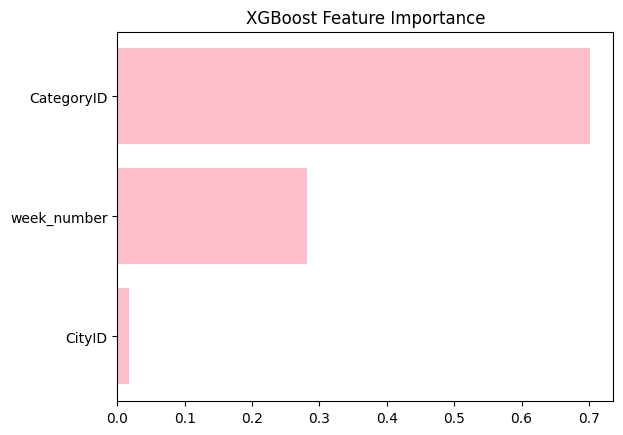

In [35]:

indices = np.argsort(xgb_model.feature_importances_) # Sorts by importance

plt.barh(
    X_train.columns[indices],
    xgb_model.feature_importances_[indices],
    color="pink"
)
plt.title("XGBoost Feature Importance")
plt.show()

**Insight:** The product category has the greatest influence on restocking needs, followed by the week number (likely due to seasonal trends). However, city/location has very little impact, suggesting that restocking decisions should focus more on product type and timing rather than location.

# Final Model Training

* Since `XGBoost` is best model, it'll be retrained on the entire dataset so the model benefits from all the data available. 

In [ ]:
final_xgb_model = XGBRegressor(random_state=42)
final_xgb_model.fit(X, y)

# Save the model

In [ ]:
import joblib

# save
joblib.dump(final_xgb_model, "xgboost_final_model.pkl")


# Conclusion

**OBSERVATIONS**
* From the SQL analysis, we observed that Confections, Meat/Poultry, and Cereals were the leading categories driving sales.

* Sales showed a seasonal trend, demand started low in January, picked up in February, fluctuated in March, and dropped sharply in April.

* We found that higher revenue does not always come from higher sales quantity — selling fewer high-value products often generates more income.

* Frequent customers accounted for a significant share of revenue, highlighting the importance of customer retention.

* Among sales persons, the difference in performance was more about product type sold than just the volume of items.

* During modeling, we discovered that product category and week (seasonality) strongly influence demand, while city/location had little impact on restocking.

* After testing multiple models, XGBoost Regressor delivered the most accurate results with the lowest error rate.

**Recommendations**

* Prioritize restocking for high-demand categories (Confections, Meat/Poultry, Cereals).

* Align inventory with seasonality: plan for higher demand in February and prepare for a drop after March, if the drop is indeed seasonal.

* Encourage sales of high-value products to maximize revenue, even if quantities are lower.

* Reward frequent buyers with loyalty programs or targeted offers to maintain strong revenue flow.

* Guide sales persons to focus efforts on categories that drive revenue rather than volume.

* Adopt the XGBoost model for weekly demand forecasting to support smarter, data-driven inventory planning.